# Teaching the network to classify inputs

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from aux import get_flow, run_fwd_np
from disp import set_plot, colors, quiver
from kernels import make_psi_rand_sgm

D = 5  # system dim

### Online learning simulation

In [2]:
# simulation params
DT = .001
t = np.arange(0, .25, DT)

IT_CUE_1 = int(round(.05//DT))
IT_CUE_2 = int(round(.15//DT))

LAM_CUE = .01/DT

# base system params
TAU = .01
B = np.eye(D)
C = np.eye(D)

N = 5000
G = 100
J_PSI = G*np.random.randn(N, D)
psi, ker = make_psi_rand_sgm(J_PSI)

# cues
us_cue = np.zeros((len(t), D))
us_cue[IT_CUE_1, :2] = LAM_CUE
us_cue[IT_CUE_2, 2:4] = LAM_CUE

t_test = np.arange(0, .75, .001)
us_test = np.zeros((len(t_test), D))
us_test[int(.1//DT), :2] = LAM_CUE
us_test[int(.2//DT), 2:4] = LAM_CUE
us_test[int(.3//DT), :2] = .5*LAM_CUE
us_test[int(.4//DT), 2:4] = 1.2*LAM_CUE
us_test[int(.5//DT), :2] = 1.2*LAM_CUE
us_test[int(.6//DT), 2:4] = .5*LAM_CUE

### Classifying 2 constant inputs

In [3]:
LAM = 50

# learning input and signals
us_learn = np.zeros((len(t), D))
ls_learn = np.zeros((len(t), D))

us_learn[(t < 0.05), :2] = LAM  # support state in direction of (1, ..., 1, 0, ..., 0, 0)
ls_learn[int(round(.05/DT))-1, -1] = 5/DT  # control signal in direction of (0, ..., 0, 1)

us_learn[(0.1 <= t)&(t < .15), 2:4] = LAM  # support state in direction of (0, ..., 0, 1, ..., 1, 0)
ls_learn[int(round(.15/DT))-1, -1] = -5/DT  # control signal in direction of (0, ..., 0, -1)

In [4]:
save = {'pre': {}, 'learn': {}, 'post': {}}

W = np.zeros((N, D))

# pre-learning
xs = np.nan*np.zeros((len(t), D))
xs[0, :] = np.zeros(D)

ls = np.zeros((len(t), D))

for ct, t_ in enumerate(t[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_cue[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx
    
save['pre']['xs'] = xs.copy()
save['pre']['us'] = us_cue.copy()
save['pre']['ls'] = ls.copy()

# learning
xs = np.nan*np.zeros((len(t), D))
xs[0, :] = save['pre']['xs'][-1, :]

ls = ls_learn.copy()

for ct, t_ in enumerate(t[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_learn[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx
    
    # implement plasticity rule
    if np.linalg.norm(ls[ct]) > 0:
        for d in range(D):
            W[:, d] += (DT*ls[ct, d]*psi(xs[ct, :]))
    
save['learn']['xs'] = xs.copy()
save['learn']['us'] = us_learn.copy()
save['learn']['ls'] = ls.copy()

# post-learning
xs = np.nan*np.zeros((len(t_test), D))
xs[0, :] = save['learn']['xs'][-1, :]

ls = np.zeros((len(t_test), D))

for ct, t_ in enumerate(t_test[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_test[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx
    
save['post']['xs'] = xs.copy()
save['post']['us'] = us_test.copy()
save['post']['ls'] = ls.copy()

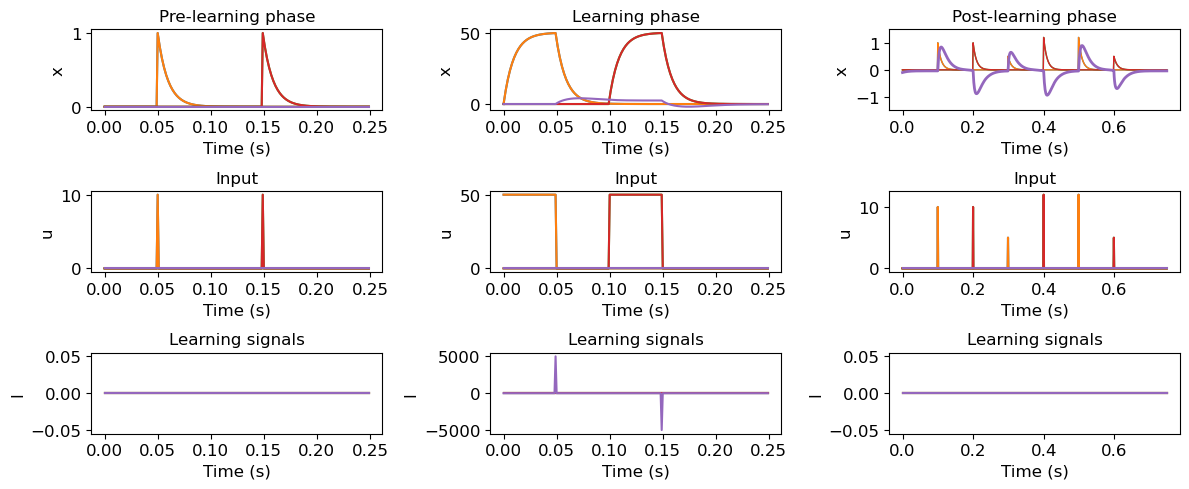

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(12, 5), tight_layout=True)

axs[0, 0].plot(t, save['pre']['xs'])
set_plot(axs[0, 0], x_label='Time (s)', y_label='x', title='Pre-learning phase')
axs[1, 0].plot(t, save['pre']['us'])
set_plot(axs[1, 0], x_label='Time (s)', y_label='u', title='Input')
axs[2, 0].plot(t, save['pre']['ls'])
set_plot(axs[2, 0], x_label='Time (s)', y_label='l', title='Learning signals')

axs[0, 1].plot(t, save['learn']['xs'])
set_plot(axs[0, 1], x_label='Time (s)', y_label='x', title='Learning phase')
axs[1, 1].plot(t, save['learn']['us'])
set_plot(axs[1, 1], x_label='Time (s)', y_label='u', title='Input')
axs[2, 1].plot(t, save['learn']['ls'])
set_plot(axs[2, 1], x_label='Time (s)', y_label='l', title='Learning signals')

axs[0, 2].plot(t_test, save['post']['xs'][:, :4], lw=1)
axs[0, 2].plot(t_test, save['post']['xs'][:, 4], lw=2)
set_plot(axs[0, 2], y_lim=(-1.5, 1.5), x_label='Time (s)', y_label='x', title='Post-learning phase')
axs[1, 2].plot(t_test, save['post']['us'])
set_plot(axs[1, 2], x_label='Time (s)', y_label='u', title='Input')
axs[2, 2].plot(t_test, save['post']['ls'])
set_plot(axs[2, 2], x_label='Time (s)', y_label='l', title='Learning signals')

fig.savefig('ms/3_classification.svg')